 # Построение осцилляторов и индикаторов на основе акций Microsoft

## Загрузка данных из файла

In [79]:
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tulipy as ti
%matplotlib inline
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
df = joblib.load("../Documents/MSFT.pkl")
df['test'] = df['open']
df.test = df.test.shift(-1) #сдвигаю вниз
y = df['open'].values
z = df['close'].values
high = df['high'].values
low = df['low'].values
#df = df.dropna()           #удаляю первую строку
new_o = df.loc[:,['open']] #фильтр
ewma = pd.Series.ewm

## Cкользящая средняя
![SMA-1.png](img/SMA-1.png)

где SMAt – значение простого скользящего среднего в период времени t;

n – интервал сглаживания;

Pt-i – значение случайной величины на момент (t-i).

In [80]:
#скользящая средняя
def moving_average(new_o, n): 
    MA = pd.Series(new_o['open'].rolling(window=n).mean())
    return MA

## Экспоненциальное скользящее среднее
![EMA-1.png](img/EMA-1.png)

α – весовой коэффициент в интервале от 0 до 1, отражающий скорость старения прошлых данных: чем выше его значение, тем больший удельный вес имеют новые наблюдения случайной величины, и тем меньший старые;

Pt – значение случайной величины в период времени t;

EMAt-1 – значение экспоненциального скользящего среднего в период времени (t-1).

In [81]:
#Экспоненциальная скользящая средняя
def exponential_moving_average(new_o, n):
    EMA = pd.Series(new_o['open'].ewm(span=n, min_periods=n).mean())
    return EMA

## Построение графиков средних скользящих

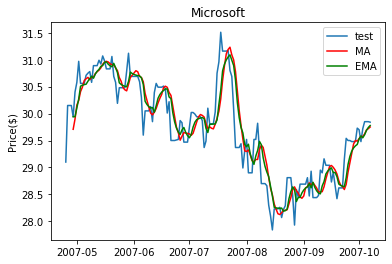

In [94]:
new_o['EMA'] = exponential_moving_average(new_o, 5)
new_o['MA'] = moving_average(new_o, 5)
df['MA'] = new_o['MA']
df['EMA'] = new_o['EMA']
df = df.loc['2007-04-25':'2007-10-07']  #фильтр для детализации
plt.plot(df.index,df['test'], label='test')
plt.plot(df.index,df['MA'],label='MA', color = 'red')
plt.plot(df.index,df['EMA'],label='EMA', color = 'green')
plt.legend()
plt.title('Microsoft')
plt.ylabel('Price($)')
plt.show()

## RSI
![RSI-formula.png](img/RSI-formula.png)

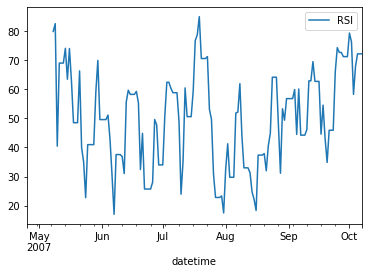

In [95]:
#RSI индикатор
def RSI(series, period):
    delta = series.diff()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[period-1]] = np.mean( u[:period] ) #сумма средних увеличений
    u = u.drop(u.index[:(period-1)])
    d[d.index[period-1]] = np.mean( d[:period] ) #сумма средних уменьшений
    d = d.drop(d.index[:(period-1)])
    rs = ewma(u, span=period-1).mean() / ewma(d, span=period-1).mean()
    return 100 - 100 / (1 + rs)
new_o['RSI'] = RSI(df.close, 14) 
df['RSI'] = new_o['RSI']
df.plot(y=['RSI'])

## Стохастический осциллятор
![stochastic-1.png](img/stochastic-1.png)

где N – количество периодов;

Ct – цена закрытия в период времени t;

HN – максимальное значение цены за последние N периодов;

LN – минимальное значение цены за последние N периодов.

Формула расчета %D в период времени t представляет собой простое скользящее среднее %K с интервалом сглаживания m.

![stochastic-2.png](img/stochastic-2.png)

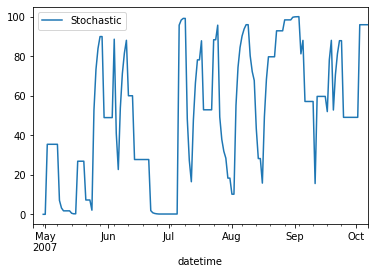

In [96]:
#Стохастик индикатор
def stochastic_oscillator(df, n):
    SOk = pd.Series((df['close'] - df['low']) / (df['high'] - df['low']))*100
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean())
    return SOd
df['Stochastic'] = stochastic_oscillator(df, 5)
df.plot(y=['Stochastic'])

## Библиотека Tulip


In [90]:
#Tulip Indicators
stoch_k, stoch_d = ti.stoch(high, low, z, 5, 3, 3)
sma = ti.sma(y, 5)
rsi = ti.rsi(z, 14)
ema = ti.ema(y,5)
print('MA: ', sma)
print('EMA: ',ema)
print('RSI: ',rsi)
print('Stochastic: ',stoch_d)

MA:  [29.708 29.898 30.158 ... 78.778 79.278 80.314]
EMA:  [28.99       29.02666667 29.40111111 ... 78.67755184 79.5383679
 81.0055786 ]
RSI:  [80.13401125 74.71798451 77.28224909 ... 80.57381946 90.11144749
 93.66999861]
Stochastic:  [93.87931034 92.42898238 82.69909537 ... 88.88888889 77.6048422
 66.3207955 ]


In [91]:
new_o

,open,RSI,EMA,MA
datetime,,,,
2007-04-25,28.99,NaN,NaN,NaN
2007-04-26,29.10,NaN,NaN,NaN
2007-04-27,30.15,NaN,NaN,NaN
2007-04-28,30.15,NaN,NaN,NaN
2007-04-29,30.15,NaN,29.942607,29.708
2007-04-30,29.94,NaN,29.941654,29.898
2007-05-01,30.40,NaN,30.103934,30.158
2007-05-02,30.58,NaN,30.269066,30.244
2007-05-03,30.97,NaN,30.508950,30.408


In [93]:
df

,open,high,low,close,vol0,vol1,datetime,assetCode,test,RSI,Stochastic,MA,EMA
datetime,,,,,,,,,,,,,
2007-04-25,28.99,28.9900,28.9900,28.9900,5556.0,38064896.0,2007-04-25 16:02:00,MSFT_1,29.10,NaN,NaN,NaN,NaN
2007-04-26,29.10,29.1100,29.1000,29.1000,1084750.0,57165056.0,2007-04-26 16:01:00,MSFT_1,30.15,NaN,NaN,NaN,NaN
2007-04-27,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,30.15,NaN,NaN,NaN,NaN
2007-04-28,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,30.15,NaN,NaN,NaN,NaN
2007-04-29,30.15,30.1500,30.1200,30.1200,1111878.0,125368502.0,2007-04-27 16:01:00,MSFT_1,29.94,NaN,NaN,29.708,29.942607
2007-04-30,29.94,29.9500,29.9400,29.9400,2001071.0,62792593.0,2007-04-30 16:01:00,MSFT_1,30.40,NaN,0.000000,29.898,29.941654
2007-05-01,30.40,30.4200,30.4000,30.4000,1126750.0,69829805.0,2007-05-01 16:01:00,MSFT_1,30.58,NaN,0.000000,30.158,30.103934
2007-05-02,30.58,30.6100,30.5800,30.6100,1273233.0,71197735.0,2007-05-02 16:01:00,MSFT_1,30.97,NaN,35.405537,30.244,30.269066
2007-05-03,30.97,30.9700,30.9700,30.9700,1104358.0,80155642.0,2007-05-03 16:01:00,MSFT_1,30.56,NaN,35.405537,30.408,30.508950
